In [1]:
# Standard library imports
import csv
import itertools
import os
import os.path
import random
from glob import glob
from pathlib import Path
import zlib
import importlib

# Third-party imports
import cv2
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import skimage
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from skimage.transform import resize
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score,
                                     learning_curve, train_test_split)
from sklearn.utils import class_weight, shuffle
from tqdm import tqdm
import foolbox as fb
import tensorflow as tf
import eagerpy as ep


# Keras-specific imports
import keras
from keras import backend as K
from keras import layers, models, optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (Activation, AveragePooling2D, BatchNormalization,
                          Conv2D, Dense, Dropout, Flatten, Lambda, MaxPool2D,
                          MaxPooling2D)
from keras.models import Model, Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.utils import to_categorical

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
model = tf.keras.models.load_model('assets/models/ASL_DNN_3D.h5')
fmodel = fb.TensorFlowModel(model, bounds=(0, 1), preprocessing=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [4]:
X_test_pca = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_test_pca.npy")
y_test = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_test.npy")
y_testHot = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_testHot.npy")
X_test = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_test.npy")

In [5]:
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "delete", "nothing", "space"]

### Attack

In [6]:
from foolbox.attacks import L2PGD

attack = L2PGD()

# Choose an image and label from your test set
image, label = X_test[0], y_test[0]
#image = ep.astensor(np.expand_dims(image, axis=0)) 

label = np.array([label])
label = ep.astensor(label)


In [7]:
# epsilons = np.linspace(0.0, 0.005, num=20)

# # Apply the attack
# adversarial_image, adversarial_label, success = attack(fmodel, image, criterion=fb.criteria.Misclassification(label), epsilons=epsilons)

# # Check if the attack was successful
# if success:
#     print("Attack successful!")
# else:
#     print("Attack failed.")


___

In [8]:
# Wrap your model into a Foolbox model
fmodel = fb.TensorFlowModel(model, bounds=(0, 1), preprocessing=None)

# Choose an attack method, e.g., FGSM (Fast Gradient Sign Method)
attack = fb.attacks.FGSM()

In [9]:
# Prepare an example input image and its correct label
import numpy as np
image = np.random.rand(1, 50, 50, 3).astype(np.float32) # Example image
image = tf.convert_to_tensor(image, dtype=tf.float32)  # Convert to TensorFlow tensor

label = np.array([3]) # Example true label

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.25, shuffle=True, random_state=25) 


In [11]:
images = X_test

labels = y_test

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(batch_idx, original_images, adversarial_images, labels, n=5):
    num_images_to_plot = min(n, len(original_images))
    plt.figure(figsize=(10, 6))  # Adjusted for three rows of images
    
    for i in range(num_images_to_plot):
        # Plot original images
        plt.subplot(3, num_images_to_plot, i + 1)
        plt.imshow(original_images[i])
        plt.title(f"Orig: {labels[i]}")
        plt.axis('off')
        
        # Calculate noise/difference and amplify for visualization
        noise = adversarial_images[i] - original_images[i]
        # Normalize the noise to [0, 1] for visualization
        noise_normalized = (noise - noise.min()) / (noise.max() - noise.min())
        plt.subplot(3, num_images_to_plot, num_images_to_plot + i + 1)
        plt.imshow(noise_normalized, cmap='viridis')  # Using a colormap to enhance visibility
        plt.title("Amplified Noise")
        plt.axis('off')
        
        # Plot adversarial images
        plt.subplot(3, num_images_to_plot, 2 * num_images_to_plot + i + 1)
        adv_img = adversarial_images[i] if adversarial_images.ndim == 4 else adversarial_images
        plt.imshow(adv_img)
        plt.title("Adv")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [13]:
model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(), 
                  metrics=['accuracy'])

In [14]:
len(images)

4350

In [15]:
# Assuming you have a batch_size defined
batch_size = 50
original_confidences = []
adv_confidences = []
num_epochs = 1

j = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        batch_labels = labels[i:i + batch_size]
        batch_tensor = tf.convert_to_tensor(batch, dtype=tf.float32)

        # Generate adversarial examples
        criterion = fb.criteria.Misclassification(labels=batch_labels)
        epsilons = [0.01, 0.1, 0.15, 0.2]  # Example epsilon values
        adversarials, _, success = attack(fmodel, inputs=batch_tensor, criterion=criterion, epsilons=epsilons)

        print(f"Batch {i//batch_size} success rate:", success.numpy().mean())

        # Convert tensors to NumPy arrays for plotting
        adversarials_np = np.array([adv.numpy() for adv in adversarials]) if isinstance(adversarials, list) else adversarials.numpy()
        # Convert adversarials to TensorFlow tensor for model prediction
        adversarials_tensor = tf.stack(adversarials, axis=0)
        
        adversarials_tensor = tf.reshape(adversarials_tensor, (-1, 50, 50, 3))

        # Get model predictions for both original and adversarial images
        original_predictions = fmodel(batch_tensor).numpy()
        adv_predictions = fmodel(adversarials_tensor).numpy()

        # Extract the confidence scores for the true class (or top paredicted class)
        original_confidences.extend(np.max(original_predictions, axis=1))
        adv_confidences.extend(np.max(adv_predictions, axis=1))

        n=5
        # Select a subset for plotting
        selected_batch = batch[:n]  # Adjust the slice as necessary
        selected_adversarials = adversarials[0].numpy()[:n]    
        selected_labels = batch_labels[:n]  # Adjust the slice as necessary

        # # if j <= 3:
        # #     # Plotting images from the current batch
        # #     plot_images(i//batch_size, selected_batch, selected_adversarials, selected_labels, n=5)
        # #     j+=1
        
        # Combine original and adversarial examples
        combined_images = tf.concat([batch_tensor, adversarials_tensor], axis=0)
        # Assuming the labels for adversarials should match the original labels, you'll need to replicate the labels
        replicated_labels = tf.repeat(batch_labels, repeats=tf.shape(adversarials)[0], axis=0)

        # Combine the original labels and the replicated labels for adversarials
        combined_labels = tf.concat([batch_labels, replicated_labels], axis=0)
        
        # Shuffle the combined dataset
        idx = tf.random.shuffle(tf.range(combined_images.shape[0]))
        combined_images = tf.gather(combined_images, idx)
        combined_labels = tf.gather(combined_labels, idx)

        # Assuming 'num_classes' is the number of classes in your dataset
        num_classes = 30  # Adjust this to match your actual number of classes

        # One-hot encode the labels
        combined_labels_one_hot = to_categorical(combined_labels, num_classes=num_classes)

        # Now use the one-hot encoded labels for training
        model.train_on_batch(combined_images, combined_labels_one_hot)


Epoch 1/1
Batch 0 success rate: 0.905
Batch 1 success rate: 0.98
Batch 2 success rate: 1.0
Batch 3 success rate: 1.0
Batch 4 success rate: 0.98


Batch 5 success rate: 0.96


Batch 6 success rate: 0.98
Batch 7 success rate: 0.98
Batch 8 success rate: 0.96
Batch 9 success rate: 0.945
Batch 10 success rate: 0.96
Batch 11 success rate: 0.98
Batch 12 success rate: 1.0
Batch 13 success rate: 0.92
Batch 14 success rate: 0.98
Batch 15 success rate: 0.96
Batch 16 success rate: 0.98
Batch 17 success rate: 0.98
Batch 18 success rate: 0.98
Batch 19 success rate: 0.96
Batch 20 success rate: 1.0
Batch 21 success rate: 0.92
Batch 22 success rate: 1.0
Batch 23 success rate: 0.98
Batch 24 success rate: 0.99
Batch 25 success rate: 0.98
Batch 26 success rate: 0.965
Batch 27 success rate: 0.96
Batch 28 success rate: 0.94
Batch 29 success rate: 0.94
Batch 30 success rate: 0.96
Batch 31 success rate: 0.98
Batch 32 success rate: 0.98
Batch 33 success rate: 0.92
Batch 34 success rate: 0.94
Batch 35 success rate: 0.94
Batch 36 success rate: 1.0
Batch 37 success rate: 0.96
Batch 38 success rate: 0.98
Batch 39 success rate: 0.98
Batch 40 success rate: 0.98
Batch 41 success rate: 0.9

In [16]:
model.save("assets/models/ASL_Adv_FD.h5")
model.save("assets/models/ASL_Adv_FD.keras")

In [18]:
# Assuming test_images and test_labels are your regular test examples and their true labels
loss, accuracy = model.evaluate(X_test, y_testHot, verbose=0)
print(f"Accuracy on regular examples: {accuracy:.2f}%")

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 4350
'y' sizes: 17400


In [19]:
# Assuming test_images and test_labels are your regular test examples and their true labels
loss, accuracy = model.evaluate(combined_images, combined_labels_one_hot, verbose=0)
print(f"Accuracy on all examples: {accuracy:.2f}%")

Accuracy on all examples: 0.04%


In [20]:
#batch_size = 500
# Select a batch of test images and labels
test_batch = X_test  # Assuming test_images is defined
test_batch_labels = y_test  # Assuming test_labels is defined

test_batch_tensor = tf.convert_to_tensor(test_batch, dtype=tf.float32)

# Generate adversarial examples for the test batch
criterion = fb.criteria.Misclassification(labels=test_batch_labels)
epsilons = [0.01, 0.1, 0.15, 0.2]  # Example epsilon values
adv_test_images, _, _ = attack(fmodel, inputs=test_batch_tensor, criterion=criterion, epsilons=epsilons)

# Convert adversarial test images to the desired format (e.g., NumPy array)
adv_test_images_np = np.array([adv.numpy() for adv in adv_test_images]) if isinstance(adv_test_images, list) else adv_test_images.numpy()

# adv_test_labels would be the same as test_batch_labels since the labels do not change
adv_test_labels = test_batch_labels

KeyboardInterrupt: 

In [ ]:
adv_test_images_np_reshaped = np.reshape(adv_test_images_np, (-1, 50, 50, 3))

In [ ]:
adv_test_images_np_reshaped.shape

In [ ]:
loss, adv_accuracy = model.evaluate(adv_test_images_np, adv_test_labels, verbose=0)
print(f"Accuracy on adversarial examples: {adv_accuracy*100:.2f}%")

___

Batch 150 success rate: 0.92


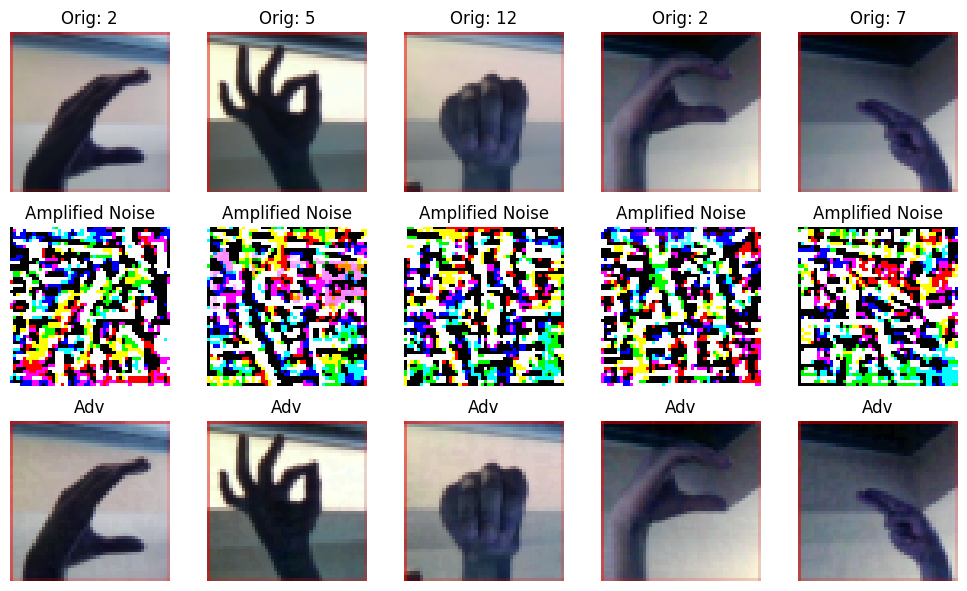

Batch 151 success rate: 0.9


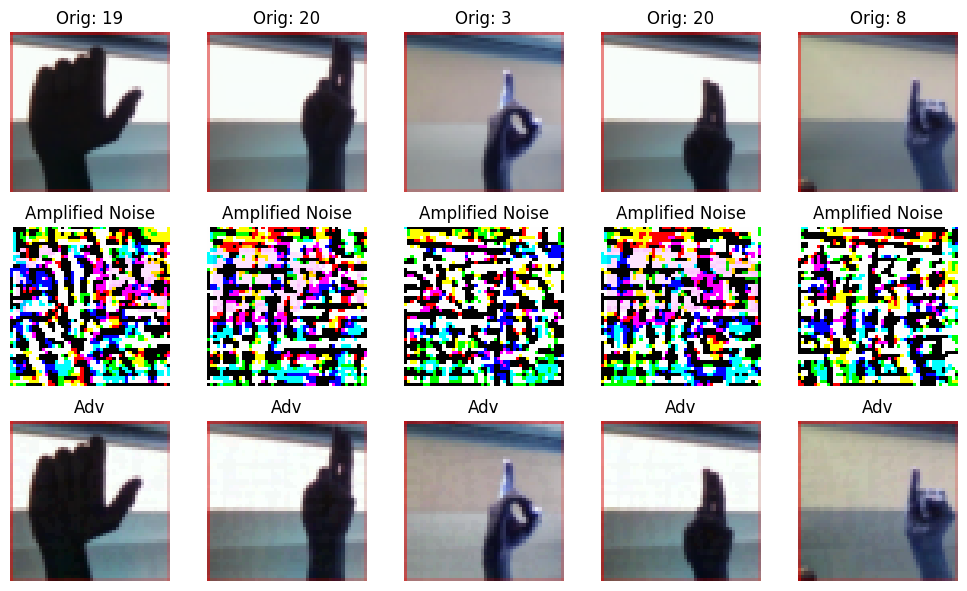

Batch 152 success rate: 1.0


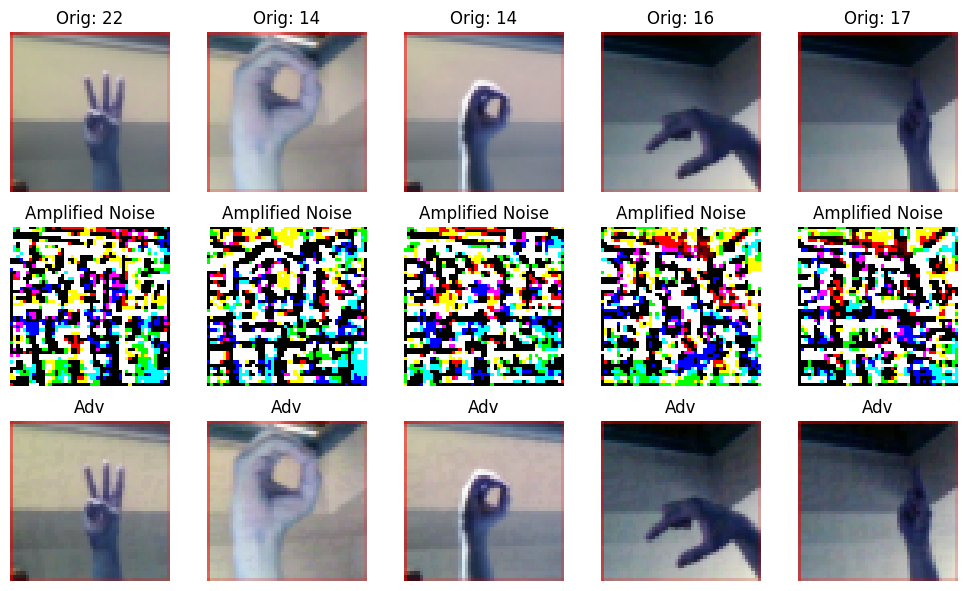

Batch 153 success rate: 1.0


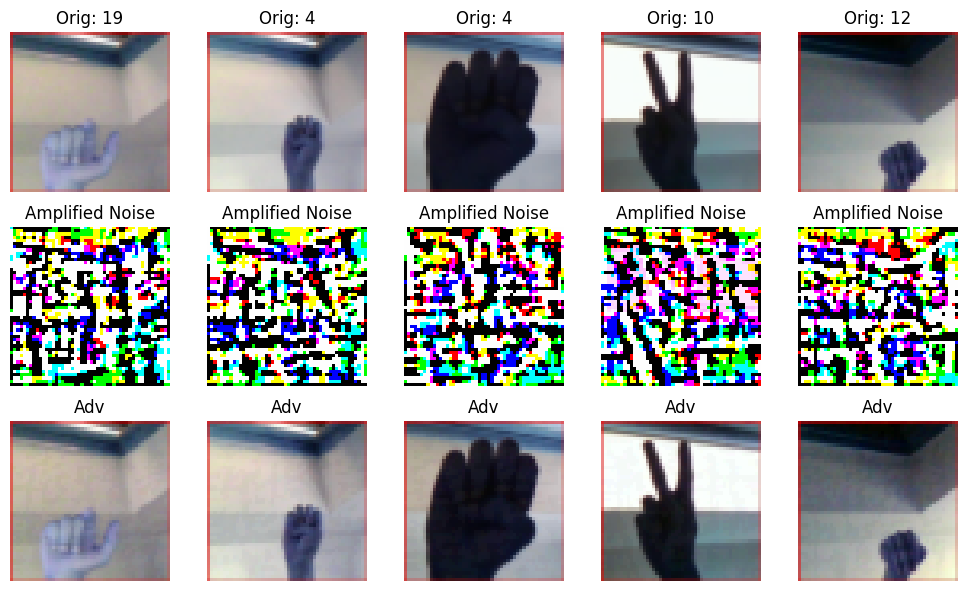

Batch 154 success rate: 0.94


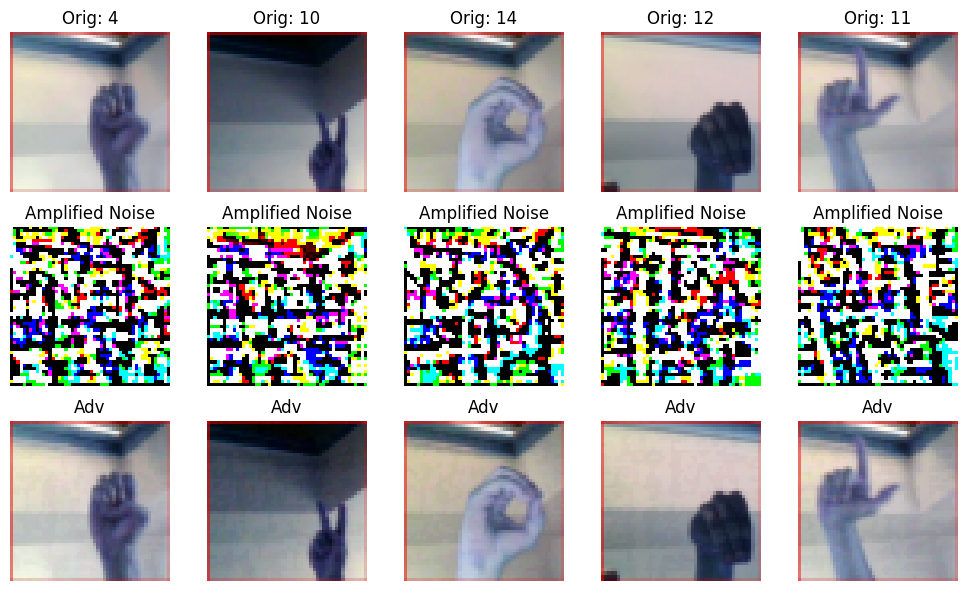

Batch 155 success rate: 0.96


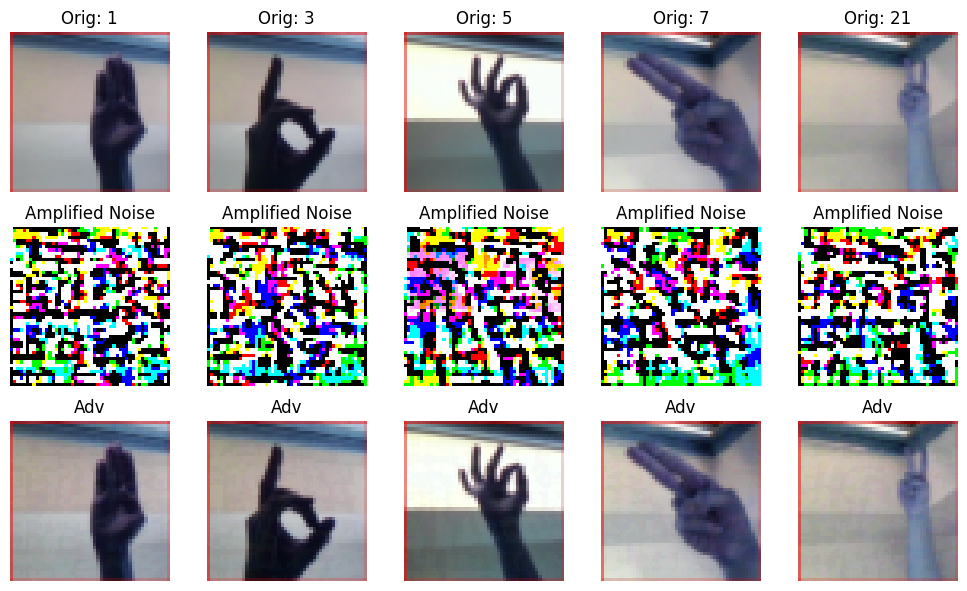

Batch 156 success rate: 0.96


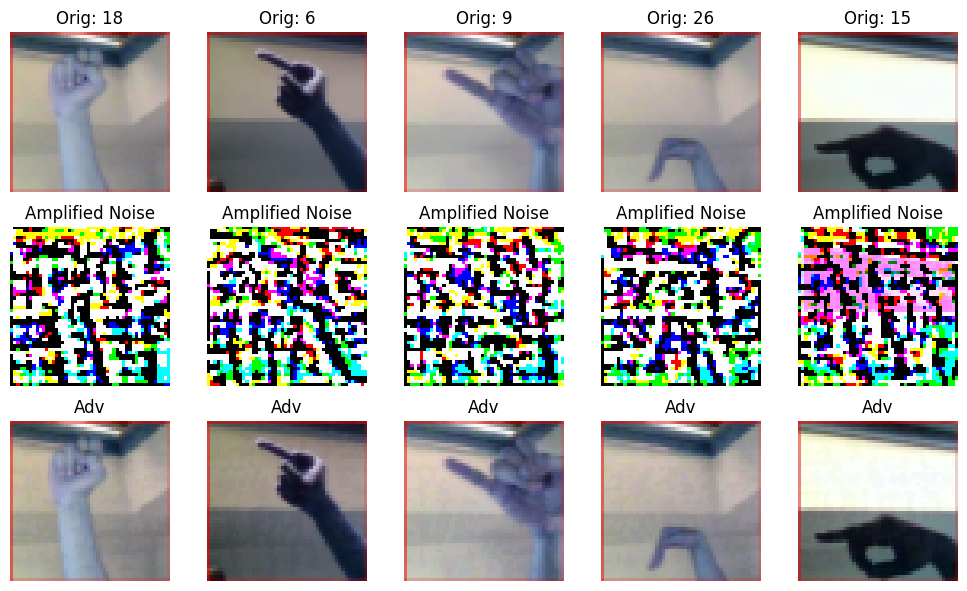

Batch 157 success rate: 1.0


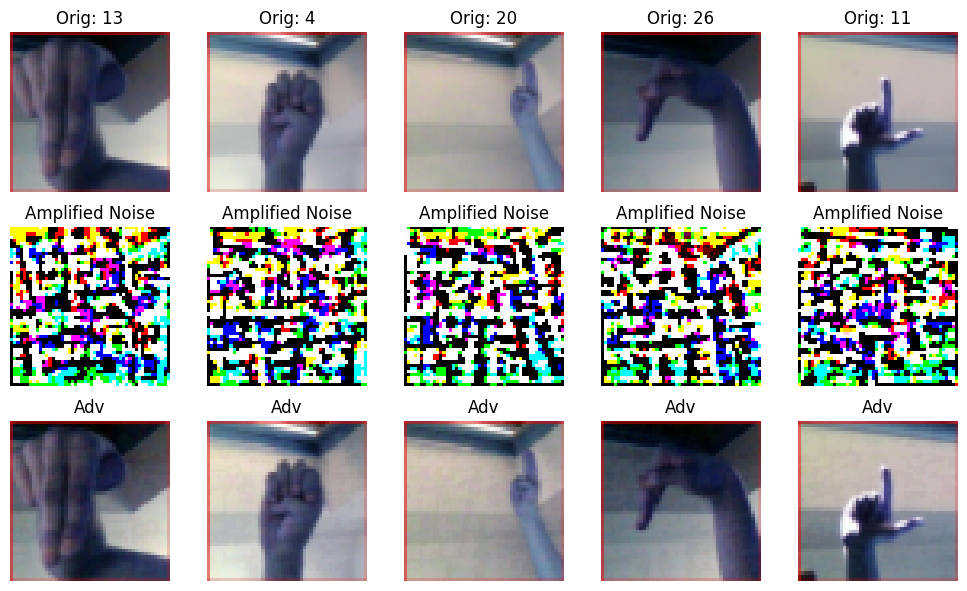

Batch 158 success rate: 0.98


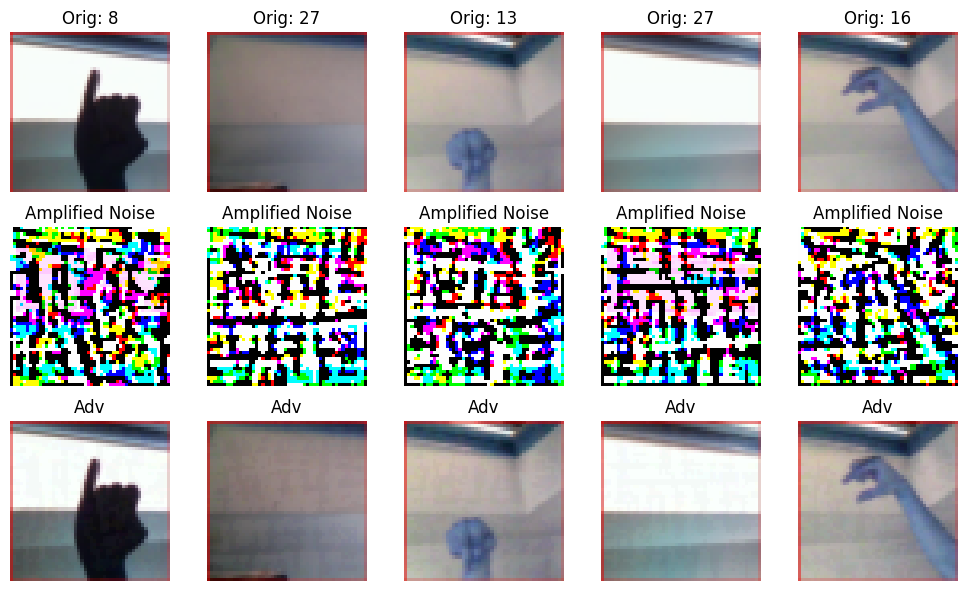

Batch 159 success rate: 0.98


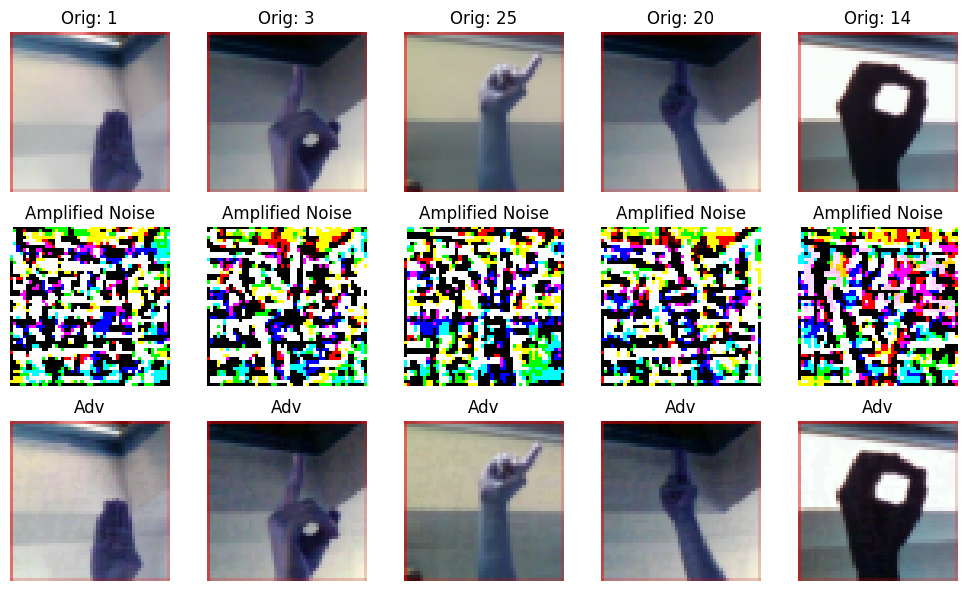

Batch 160 success rate: 0.96


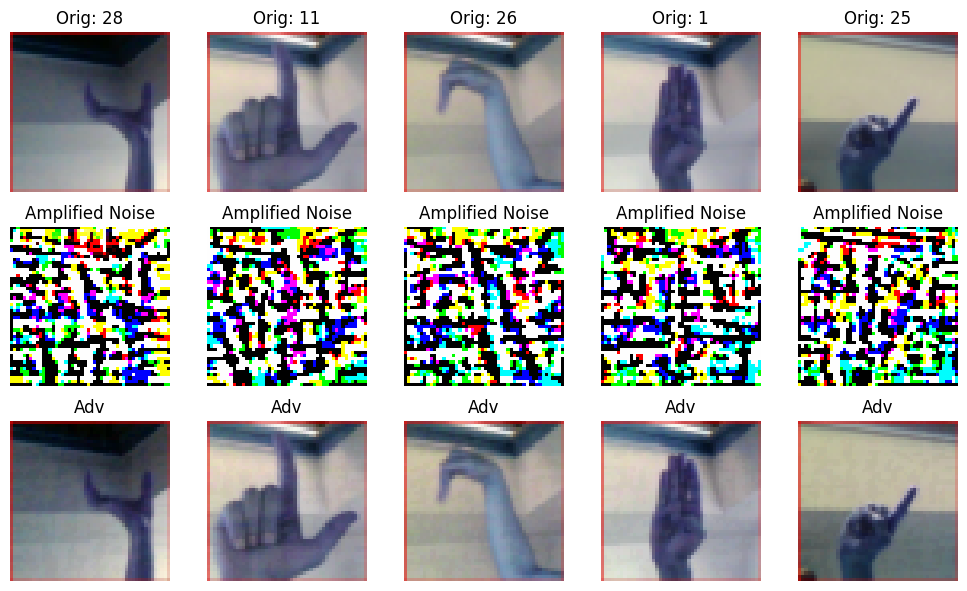

Batch 161 success rate: 0.94


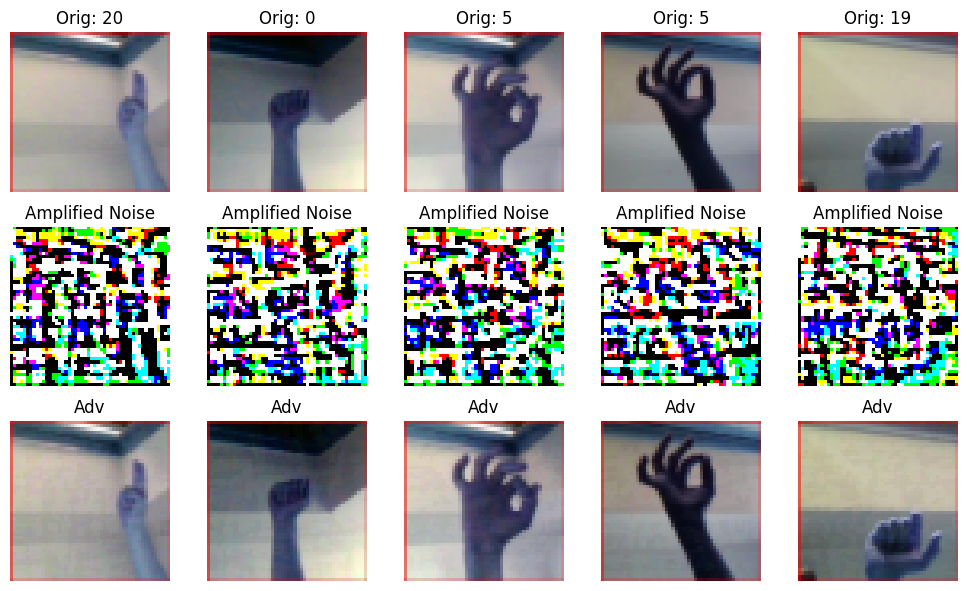

Batch 162 success rate: 0.98


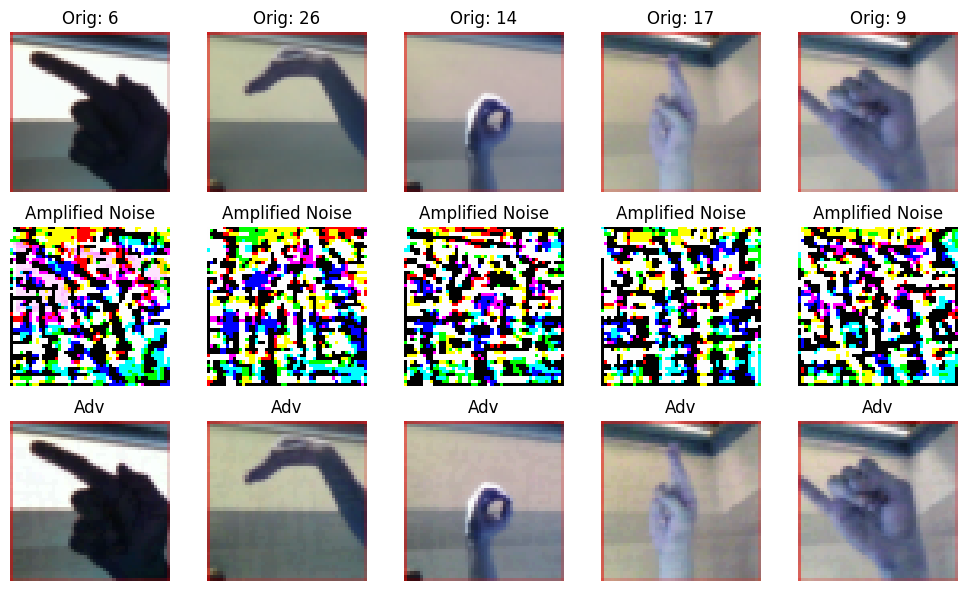

Batch 163 success rate: 0.98


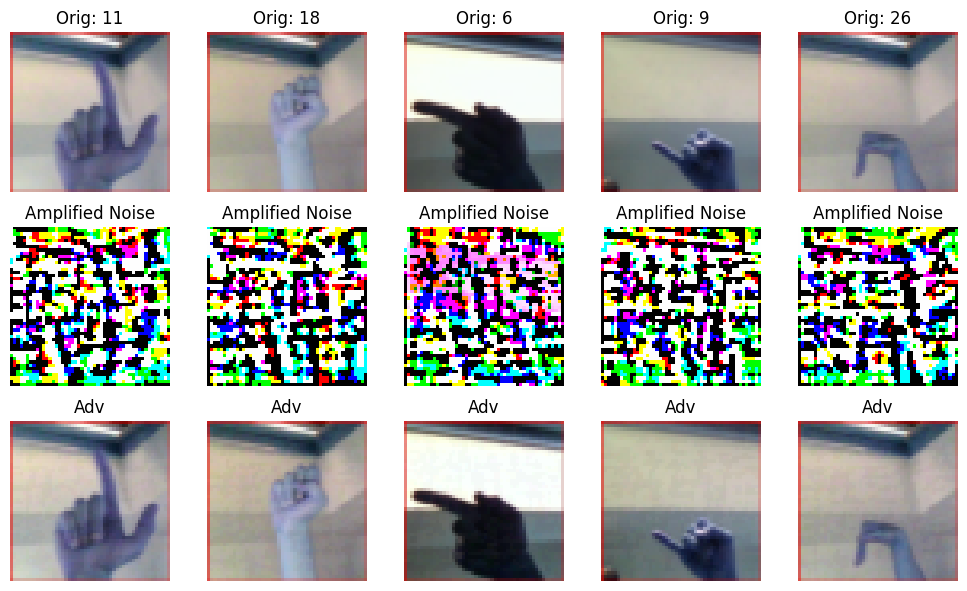

Batch 164 success rate: 1.0


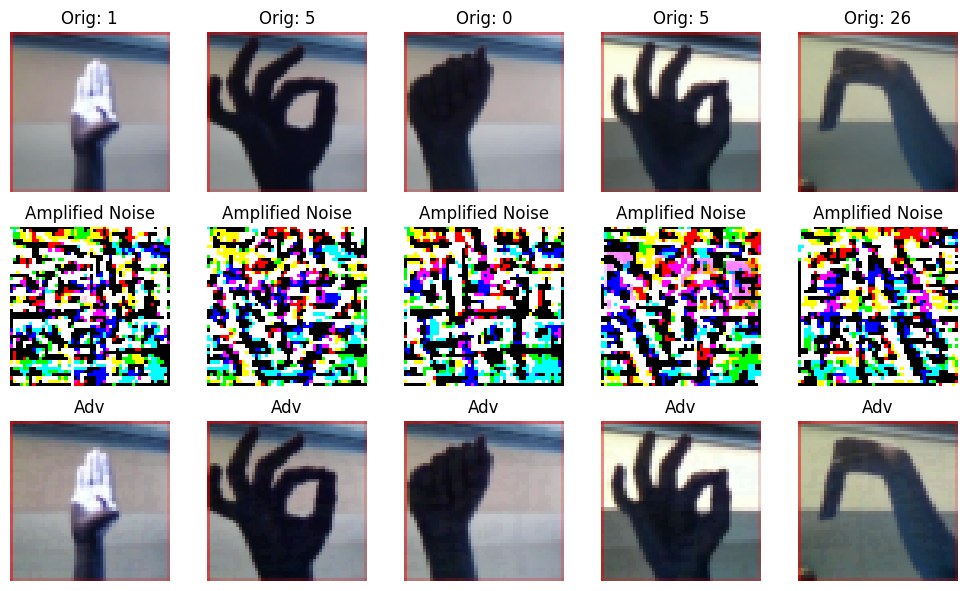

Batch 165 success rate: 0.96


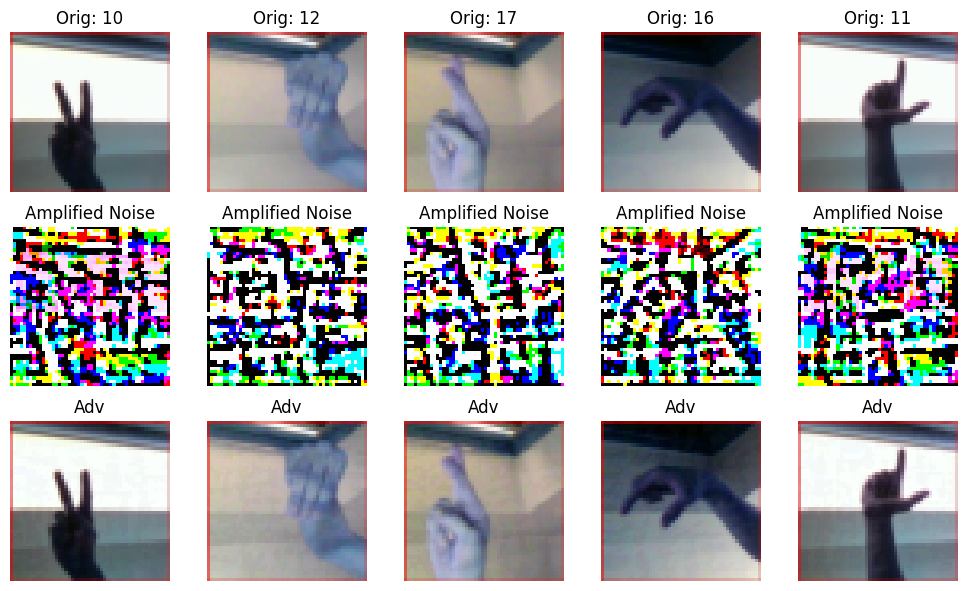

Batch 166 success rate: 0.98


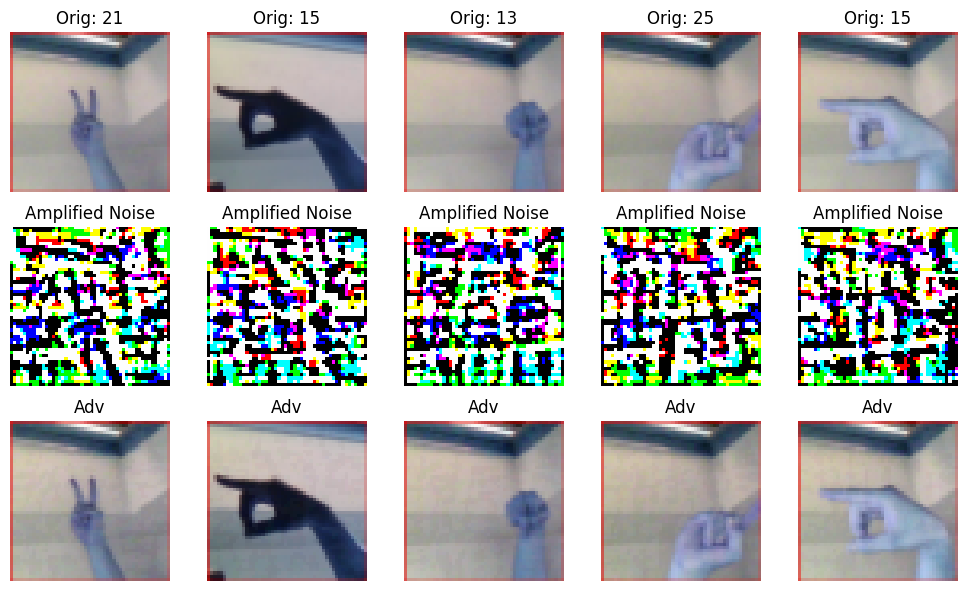

Batch 167 success rate: 1.0


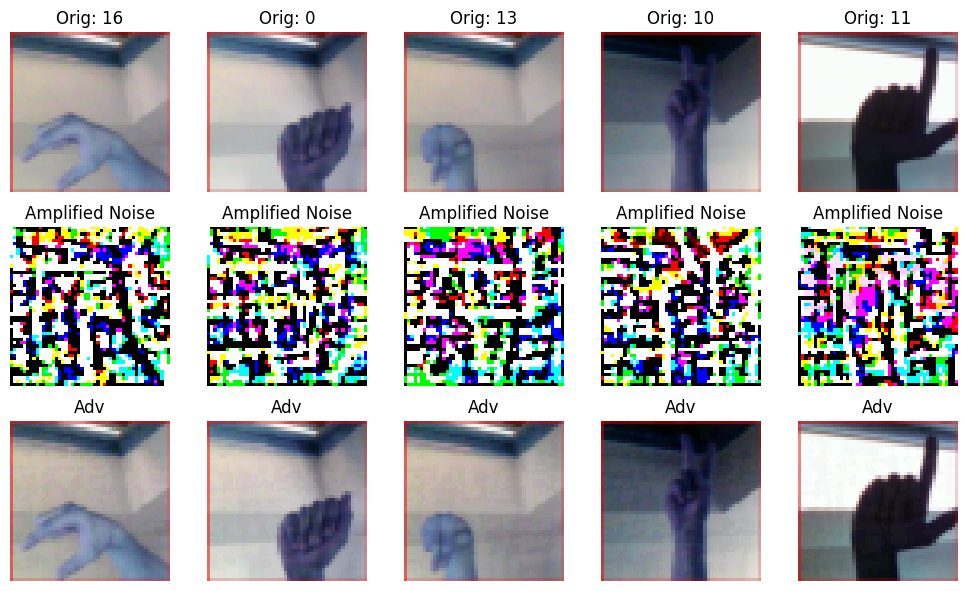

Batch 168 success rate: 0.98


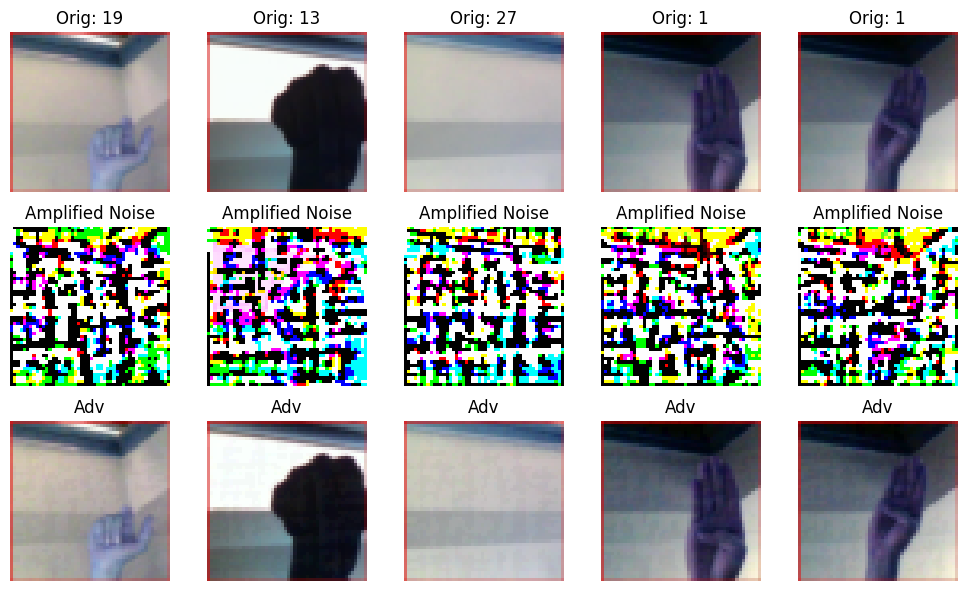

KeyboardInterrupt: 

In [16]:
# Assuming you have a batch_size defined
batch_size = 50
original_confidences = []
adv_confidences = []
for i in range(0, len(images), batch_size):
    batch = images[i:i+batch_size]
    batch_labels = labels[i:i + batch_size]
    batch_tensor = tf.convert_to_tensor(batch, dtype=tf.float32)
    
    criterion = fb.criteria.Misclassification(labels=batch_labels)

    # Apply the attack
    epsilons = [0.01, 0.1, 0.15, 0.2]
    adversarials, _, success = attack(fmodel, inputs=batch_tensor, criterion=criterion, epsilons=epsilons)

    # Display success rate for the batch
    print(f"Batch {i//batch_size} success rate:", success.numpy().mean())

    # Convert tensors to NumPy arrays for plotting
    adversarials_np = np.array([adv.numpy() for adv in adversarials]) if isinstance(adversarials, list) else adversarials.numpy()
    # Convert adversarials to TensorFlow tensor for model prediction
    adversarials_tensor = tf.stack(adversarials, axis=0)
    
    adversarials_tensor = tf.reshape(adversarials_tensor, (-1, 50, 50, 3))

    # Get model predictions for both original and adversarial images
    original_predictions = fmodel(batch_tensor).numpy()
    adv_predictions = fmodel(adversarials_tensor).numpy()

    # Extract the confidence scores for the true class (or top paredicted class)
    original_confidences.extend(np.max(original_predictions, axis=1))
    adv_confidences.extend(np.max(adv_predictions, axis=1))

    n=5
    # Select a subset for plotting
    selected_batch = batch[:n]  # Adjust the slice as necessary
    selected_adversarials = adversarials[0].numpy()[:n]    
    selected_labels = batch_labels[:n]  # Adjust the slice as necessary

    # Plotting images from the current batch
    plot_images(i//batch_size, selected_batch, selected_adversarials, selected_labels, n=5)

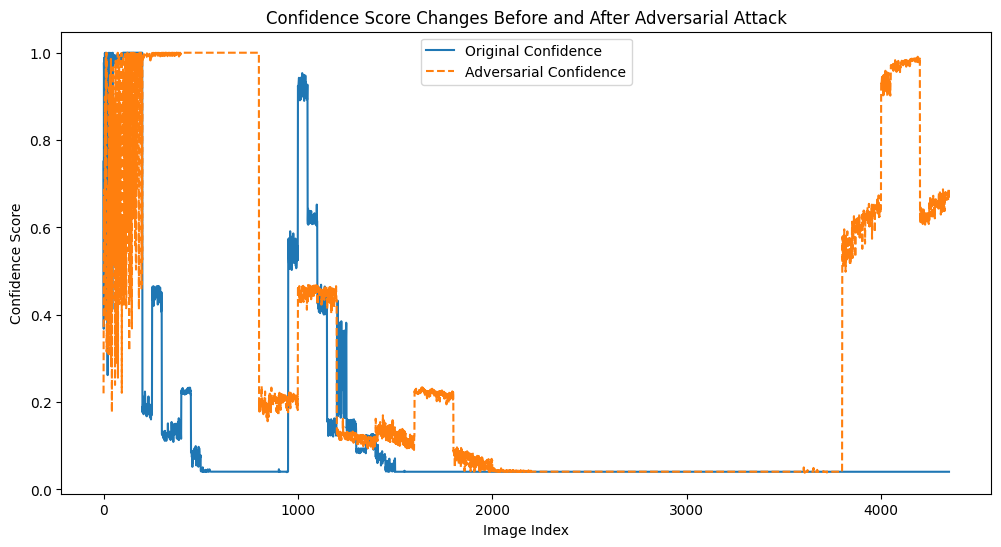

In [21]:
indices = range(len(original_confidences))  # Adjust to match the length of adv_confidences
plt.figure(figsize=(12, 6))
plt.plot(indices, original_confidences, label='Original Confidence')  # Match lengths
plt.plot(indices, adv_confidences[:len(indices)], label='Adversarial Confidence', linestyle='--')
plt.xlabel('Image Index')
plt.ylabel('Confidence Score')
plt.title('Confidence Score Changes Before and After Adversarial Attack')
plt.legend()
plt.show()

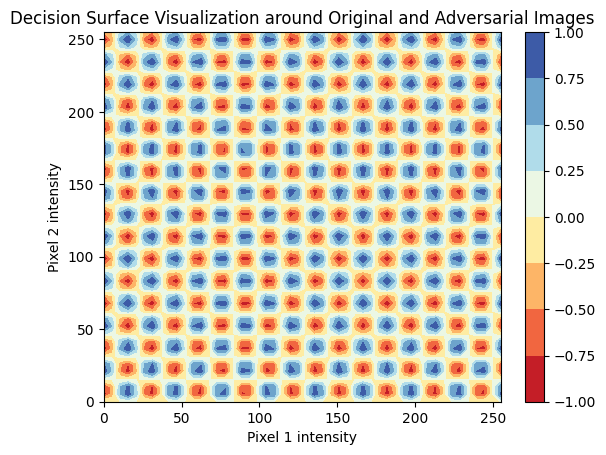

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Select an image and its adversarial counterpart
original_image = images[0]  # Replace with the correct index or method to select an image
adv_image = adversarials[0]  # Replace with the correct index or method to select the corresponding adversarial image

# Assuming original_image is a 2D array with shape (height, width, channels)
height, width, channels = original_image.shape

# Select two pixels to vary, for example the center and a corner
pixel_indices = [(height // 2, width // 2), (0, 0)]  # Center and top-left corner

# Generate a grid of values to iterate over for the two selected pixels
value_range = np.linspace(0, 255, num=50)  # Example for pixel intensity range
decision_surface = np.zeros((len(value_range), len(value_range)))

# Generate the decision surface
for i, val1 in enumerate(value_range):
    for j, val2 in enumerate(value_range):
        # Create a copy of the original image
        perturbed_image = np.copy(original_image)
        
        # Modify the two selected pixels
        perturbed_image[pixel_indices[0]] = val1
        perturbed_image[pixel_indices[1]] = val2
        
        # Add your model prediction code here
        # For example, assuming you have a function model_predict() to get predictions:
        # decision_surface[i, j] = model_predict(perturbed_image)

# The following lines are placeholders to create a fake decision surface for visualization
# Replace with your model's prediction results
decision_surface = np.sin(value_range)[:, None] * np.cos(value_range)

# Plotting
plt.contourf(value_range, value_range, decision_surface, cmap=plt.cm.RdYlBu)
plt.colorbar()
plt.xlabel('Pixel 1 intensity')
plt.ylabel('Pixel 2 intensity')
plt.title('Decision Surface Visualization around Original and Adversarial Images')
plt.show()


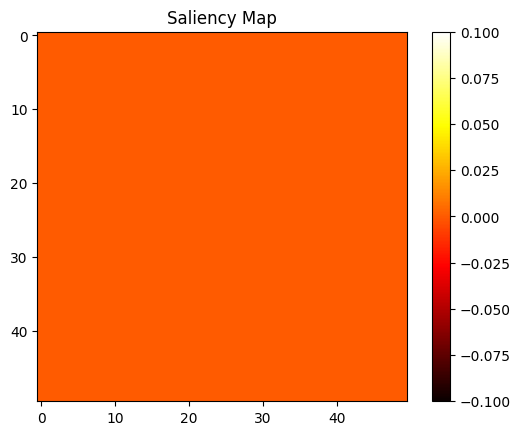

In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Ensure that the model is set to trainable to compute gradients
model.trainable = True

# Select the image for which you want to create the saliency map
image = images[100]  # Ensure this image is preprocessed (if necessary) as per model requirements

# Add a batch dimension and preprocess the image if required
image_tensor = tf.expand_dims(image, axis=0)

# Record operations for automatic differentiation
with tf.GradientTape() as tape:
    tape.watch(image_tensor)
    # Forward pass through the model to get the logits
    predictions = model(image_tensor)
    
    # Use the class with the highest probability
    class_idx = tf.argmax(predictions[0])
    class_logits = predictions[0][class_idx]

# Calculate the gradients of the class logits with respect to the input image
gradients = tape.gradient(class_logits, image_tensor)

# Check if gradients are None
if gradients is None:
    raise ValueError("Failed to compute gradients.")

# Reduce the batch dimension and extract the maximum across the channels to get the saliency map
saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)[0]

# Plot the saliency map
plt.imshow(saliency_map, cmap='hot')
plt.colorbar()
plt.title('Saliency Map')
plt.show()


In [ ]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import tensorflow as tf

# Your pre-trained model and original image
original_image = images[0]  # Replace with the correct image

# Function to apply perturbations
def apply_perturbation(x, y, intensity):
    perturbed_image = np.copy(original_image)
    # Assuming the image is grayscale; if it's color, you'll need to modify all channels
    perturbed_image[y, x] = np.clip(perturbed_image[y, x] + intensity, 0, 1)
    return perturbed_image

# Initialize the output widget
output = widgets.Output()

# Create sliders
perturb_x_slider = widgets.IntSlider(min=0, max=original_image.shape[1] - 1, step=1, description='Perturb X')
perturb_y_slider = widgets.IntSlider(min=0, max=original_image.shape[0] - 1, step=1, description='Perturb Y')
intensity_slider = widgets.FloatSlider(min=0, max=1, step=0.01, description='Intensity')

# Update function
def update_image(change):
    with output:
        # Clear the current output
        clear_output(wait=True)
        # Apply perturbation
        new_image = apply_perturbation(perturb_x_slider.value, perturb_y_slider.value, intensity_slider.value)
        # Display the new image
        plt.imshow(new_image, cmap='gray', vmin=0, vmax=1)
        plt.title('Perturbed Image')
        plt.axis('off')
        plt.show()

# Observe changes in the slider values
perturb_x_slider.observe(update_image, names='value')
perturb_y_slider.observe(update_image, names='value')
intensity_slider.observe(update_image, names='value')

# Display everything
display(perturb_x_slider, perturb_y_slider, intensity_slider)
# Display the initial image
update_image(None)  # Initial call to display the original image
display(output)  # This is where the updated images will be displayed
